In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import norm
import pandas as pd
from spectralmask import DATADIR
from spectralmask.spectrum import Spectrum
from spectralmask.mask import Mask

%matplotlib notebook

### Part 1

Using the supplied mask file, calculate and plot the CCF for the spectrum with `19940914_0022_s1d.fits` in its filename (again this could be your continuum spectrum, or the ones that I provide). 

In [2]:
s = Spectrum(name="normed_19940914_0022_s1d.fits")
wv1 = s.make_wv()
spec1 = s.interpolate_nan(wv1)

FileNotFoundError: [Errno 2] No such file or directory: './example-data/fits/normed_19940914_0022_s1d.fits'

<IPython.core.display.Javascript object>


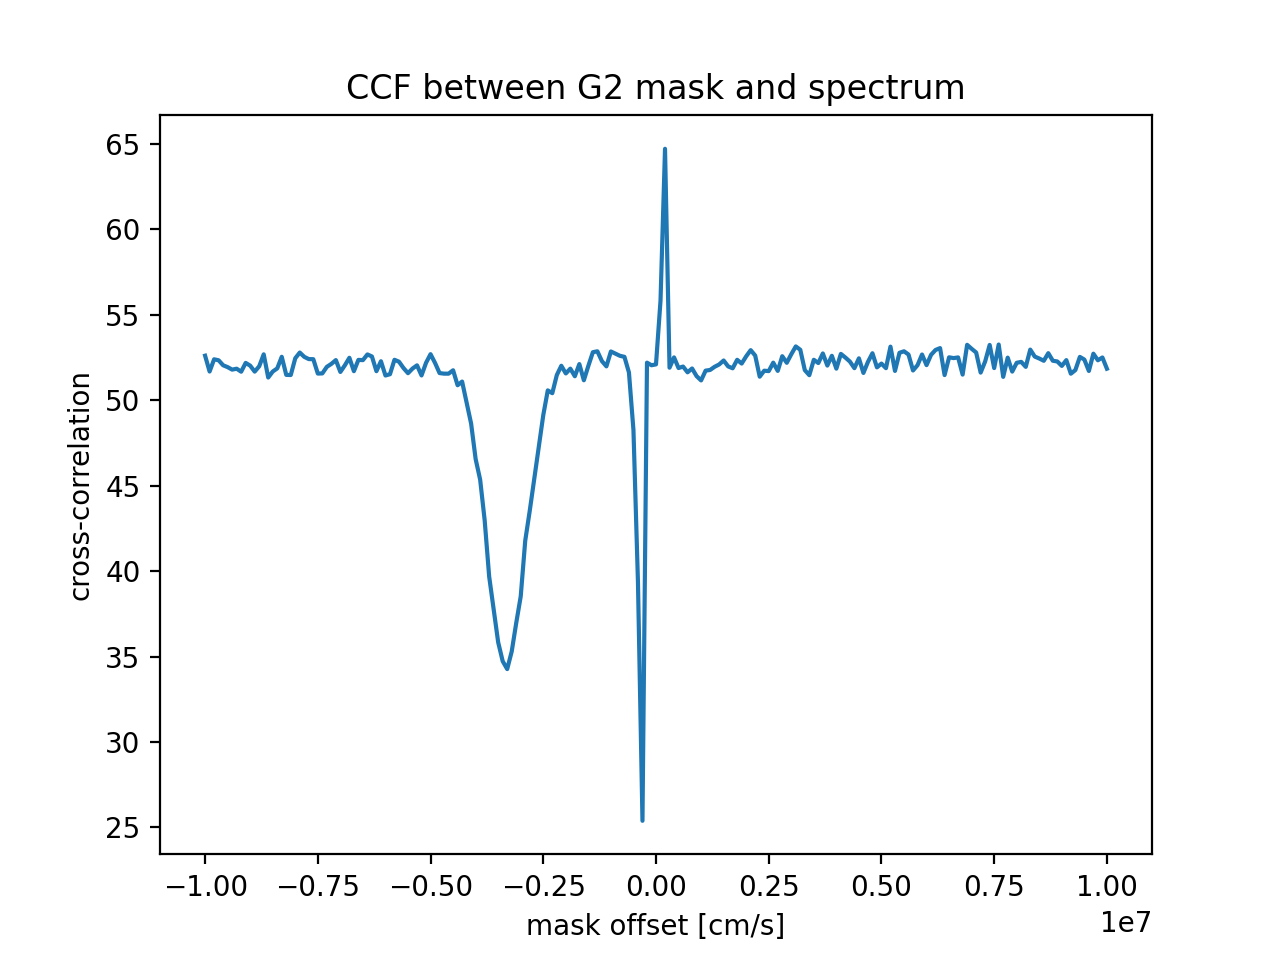

In [5]:
m = Mask(wv1,spec1)
offsets,CCF = m.CCF()

plt.figure()
plt.plot(offsets,CCF)
plt.xlabel("mask offset [cm/s]")
plt.ylabel("cross-correlation")
plt.title("CCF between G2 mask and spectrum")
plt.show()

Ok, so it makes sense that the Gaussian would be upside-down because the mask values are positive and we're cross-correlating them with absorption lines, which are negative features. I'm not sure where the other narrow spikes are coming from! Unfortunately I don't have time to investigate so I'll have to leave that to a hypothetical future work. 

### Part 2 

Estimate the RV and its uncertainty. 

Note – you can use the method described in the undergrad problems to estimate the uncertainty. *Or* you can fit a Gaussian model to the CCF and use the uncertainty on the mean of the Gaussian as the uncertainty of the RV. This does add more work, and if you have not seen model fitting in python before then its best to just use the method described above.

In [6]:
def gaussian_fit(x,y):
    
    def gaussian(x, mean, std, amp, offset):
        return amp * np.exp(-(x-mean)**2 / (2*std**2)) + offset
    
    best_vals, covar = curve_fit(gaussian,x,y,p0 = [0,1e6,-2e6,50])
    mean, std = best_vals[0],best_vals[1]
    
    return mean, np.abs(std)

In [7]:
mean, std = gaussian_fit(offsets,CCF)

In [8]:
print('The RV of this star at this time is {0:8.2f} +/- {1:8.2f} cm/s'.format(mean,std))

The RV of this star at this time is -3321048.29 +/- 431647.40 cm/s


<IPython.core.display.Javascript object>


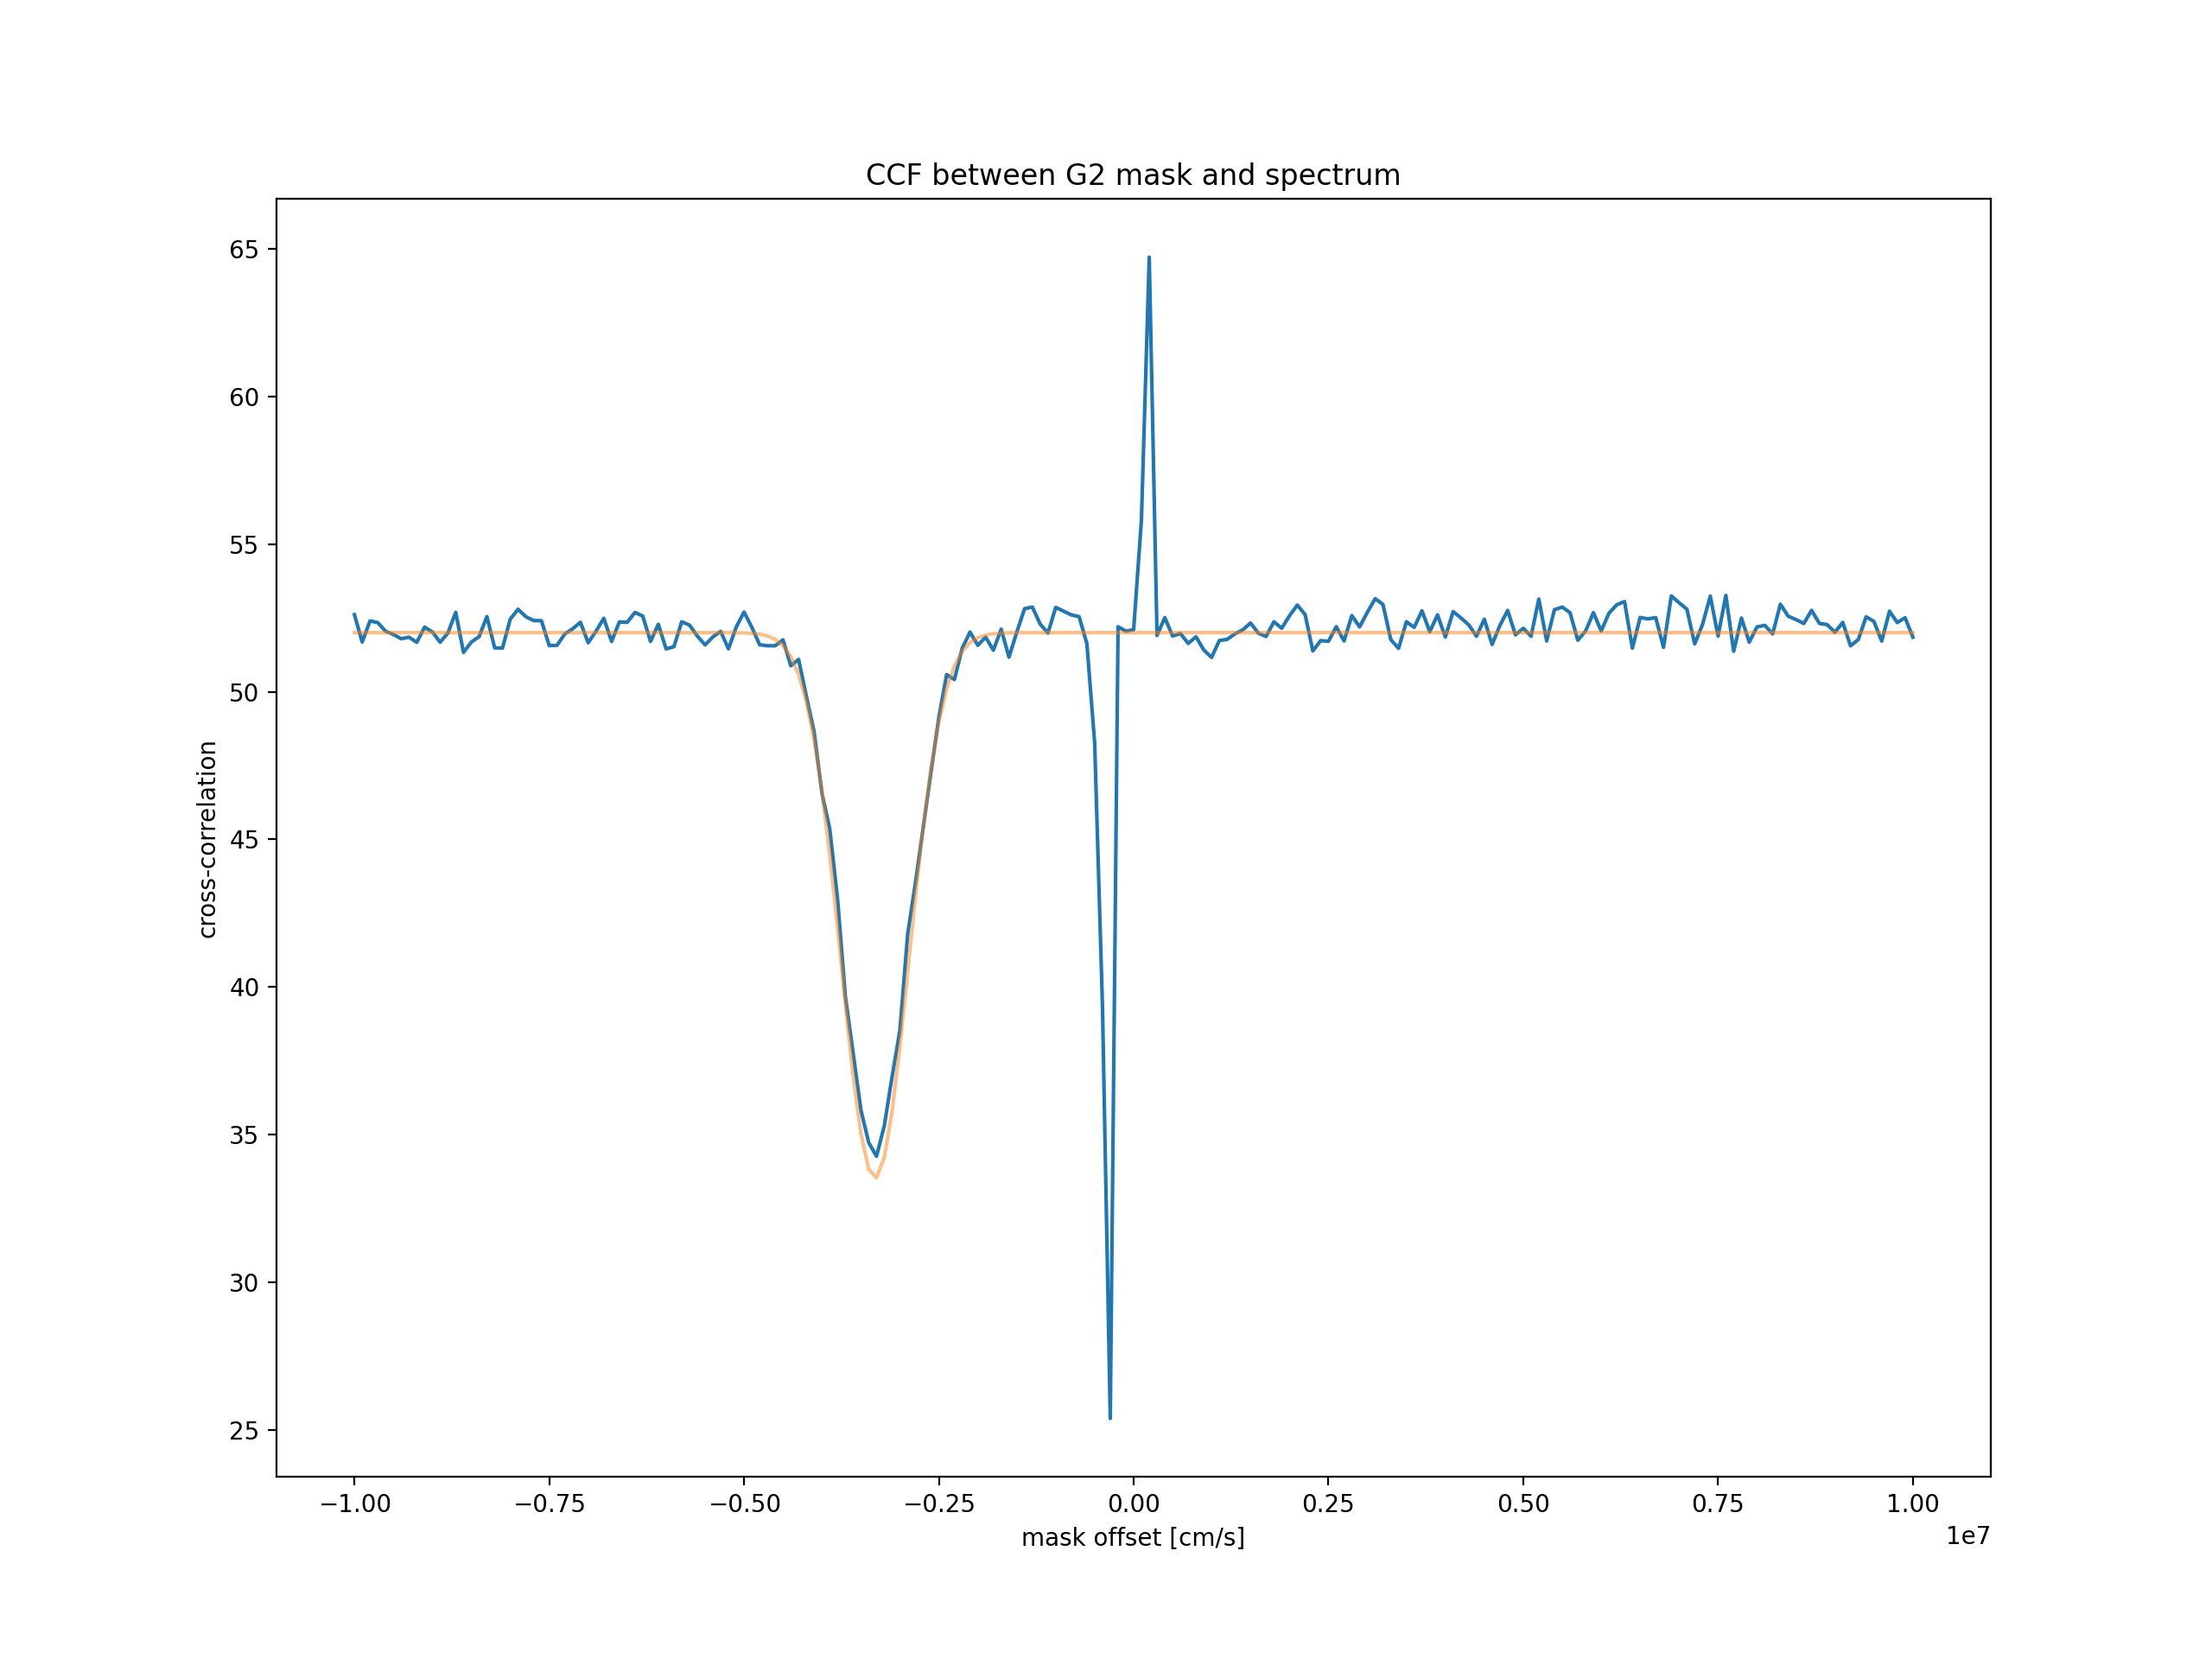

In [9]:
mean, std = gaussian_fit(offsets,CCF)
plt.figure()
plt.plot(offsets,CCF)
plt.plot(offsets,norm.pdf(offsets, mean,std)*-2e7+52,alpha=0.5)
plt.xlabel("mask offset [cm/s]")
plt.ylabel("cross-correlation")
plt.title("CCF between G2 mask and spectrum")
plt.show()